# Important Variable Selection with SNPs

Author: Nhan TV

## Content<br>
<strong>1 Data</strong><br>
<strong>2  Method</strong><br>
2.1 Partial Least Squares <br>
2.2 Machine Learning Models<br>
<strong>3 Results</strong>


In [1]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd
from math import log10
#Converting data frames back and forth between rpy2 and pandas

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#import tensorflow as tf
from sklearn import datasets
from scipy import stats
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, MultiTaskLasso, MultiTaskElasticNet, Lasso, ElasticNet, LassoCV, ElasticNetCV, MultiTaskLassoCV, MultiTaskElasticNetCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_validate
#import statsmodels.formula.api as smf
#import statsmodels.api as sm
import collections

#import xgboost as xgb
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.callbacks import EarlyStopping

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1 Data 

Load data from AI platform of Google cloud service.

In [2]:
# Using chunk size to read rice data
chunksize = 100
X_ct = pd.DataFrame()
for chunk in pd.read_csv("gs://bi-rice-data/Xcont.csv",low_memory=False, chunksize=chunksize, memory_map=True):
    X_ct = pd.concat([X_ct, chunk])

In [ ]:
X_ct.head()

,IID,1178_T,1203_C,1248_A,1282_A,1299_C,1306_A,1792_A,5752_T,6634_A,11334_C,16737_T,17263_C,21012_A,21546_A,22059_A,25777_A,27188_A,28781_T,31071_A,31478_C,31843_A,34721_T,34729_C,35239_A,35405_A,37676_A,41342_G,41749_C,42561_T,42752_T,44681_T,46283_G,46332_A,46705_A,48241_A,48402_G,48494_T,49413_T,49960_A,...,Salt.injury.at.EC12,Salt.injury.at.EC18,Time.to.flowering..from.sowing.,panicle.length,panicle.shattering,ligule.color,leaf.senescence,culm.angle,sterile.lemma.length,leaf.angle,basal.leaf.sheath.color,culm.strength,panicle.axis.attitude,culm.length,secondary.panicle.branching,culm.node.anthocyanin,ligule.length,culm.internode.underlying.colour,scent,collar.color,leaf.blade.pubescence,culm.number,pericarp.colour,ligule.shape,culm.node.underlying.colour,panicle.type,panicle.number.per.plant,leaf.width,panicle.threshability,sterile.lemma.color,culm.internode.anthocyanin,seeding.date,grain.width,endosperm.type,panicle.exsertion,leaf.blade.greenness,lemma.and.palea.pubescence,basal.leaf.sheath.anthocyanin,lemma.and.palea.color,spikelet.fertility
0,IRIS_313-10000,0,2,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,2,0,0,0,0,2,2,0,0,0,1,...,5.0,7.0,84,24.0,1.0,11,1.0,3.0,1.0,1.0,60.0,1.0,2.0,72,1.0,NaN,17,60.0,NaN,61,3,12,10.0,2.0,NaN,1.0,NaN,1.4,1.0,20.0,NaN,NaN,3.1,2.0,3.0,63,2.0,NaN,20.0,1.0
1,IRIS_313-10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5.0,7.0,86,24.0,1.0,11,3.0,1.0,3.0,2.0,60.0,1.0,2.0,74,1.0,NaN,14,60.0,NaN,61,3,9,10.0,2.0,NaN,4.0,NaN,1.3,5.0,20.0,NaN,NaN,2.4,1.0,5.0,63,2.0,NaN,20.0,3.0
2,IRIS_313-10002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7.0,9.0,114,24.0,1.0,11,3.0,3.0,1.0,1.0,60.0,1.0,2.0,60,1.0,NaN,19,41.0,NaN,61,3,20,10.0,2.0,60.0,5.0,NaN,1.2,9.0,20.0,NaN,6/26/91 0:00,2.7,1.0,3.0,60,4.0,NaN,42.0,3.0
3,IRIS_313-10007,1,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,2,0,1,0,1,0,0,0,...,9.0,9.0,108,23.0,1.0,11,7.0,2.0,3.0,3.0,60.0,3.0,2.0,143,1.0,NaN,22,60.0,NaN,60,3,23,10.0,2.0,NaN,5.0,NaN,1.9,7.0,20.0,NaN,NaN,3.3,1.0,5.0,60,4.0,NaN,52.0,3.0
4,IRIS_313-10010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7.0,9.0,136,27.0,1.0,11,5.0,5.0,3.0,3.0,60.0,5.0,2.0,106,1.0,NaN,24,41.0,NaN,61,3,16,10.0,2.0,NaN,5.0,NaN,1.4,7.0,20.0,NaN,NaN,3.1,1.0,3.0,60,2.0,NaN,52.0,3.0


Response variation.

In [5]:
grain_weight = pd.read_csv("gs://bi-rice-data/grain_weight_linear_sorted", sep = "\t")
time_flowering = pd.read_csv("gs://bi-rice-data/time_flowering_linear_sorted", sep = "\t")
y_cont = pd.read_csv("gs://bi-rice-data/Ycont.txt", sep = "\t")

In [ ]:
y_cont.columns

Index(['IID', 'Time.to.flowering..from.sowing.', 'grain.width', 'Grain.weight',
       'culm.number', 'leaf.width', 'culm.length',
       'Culm.diameter...1st.internode', 'panicle.length', 'ligule.length'],
      dtype='object')

In [ ]:
# Variable of time to flowering 
y_tfl = y_cont.iloc[:, 1]
# Variable of grain weight
y_grw = y_cont['Grain.weight']
# Varibales of time to flowering and grain weight
y_tfl_grw = y_cont.iloc[:, [1, 3]]

Variable of time flowering.

In [6]:
time_flowering = time_flowering.rename(columns = {'P':'P_tfl'})
time_flowering['variable'] = time_flowering[["SNP", "A1"]].apply(lambda x: '_'.join(x.map(str)), axis=1)
time_flowering.head()

,CHR,SNP,BP,A1,TEST,NMISS,BETA,SE,L95,U95,STAT,P_tfl,variable
45894,2,46411817,3140894,G,ADD,2266,2.997,0.5234,1.972,4.023,5.727,1.159000e-08,46411817_G
390934,12,363291768,17578105,A,ADD,2266,-3.426,0.6075,-4.617,-2.235,-5.639,1.918000e-08,363291768_A
183790,6,181775087,691967,A,ADD,2266,3.205,0.5746,2.079,4.331,5.578,2.725000e-08,181775087_A
23970,1,23655049,23655049,G,ADD,2266,2.884,0.5198,1.865,3.903,5.548,3.233000e-08,23655049_G
361954,11,341144421,24451864,G,ADD,2266,3.274,0.5952,2.107,4.440,5.500,4.229000e-08,341144421_G


Variable of grain weight

In [7]:
grain_weight = grain_weight.rename(columns = {'P':'P_grw'})
grain_weight['variable'] = grain_weight[["SNP", "A1"]].apply(lambda x: '_'.join(x.map(str)), axis=1)
grain_weight.head()

,CHR,SNP,BP,A1,TEST,NMISS,BETA,SE,L95,U95,STAT,P_grw,variable
377709,12,352270867,6557204,T,ADD,2260,0.24100,0.05371,0.13570,0.34630,4.487,0.000008,352270867_T
391742,12,363495388,17781725,C,ADD,2260,-0.14460,0.03353,-0.21030,-0.07889,-4.313,0.000017,363495388_C
158454,5,153320754,2196068,G,ADD,2260,0.08686,0.02026,0.04715,0.12660,4.287,0.000019,153320754_G
158331,5,153259075,2134389,A,ADD,2260,0.05608,0.01316,0.03029,0.08187,4.263,0.000021,153259075_A
246489,8,245730796,3701268,A,ADD,2260,0.20460,0.04801,0.11040,0.29870,4.260,0.000021,245730796_A


In [8]:
tfl_grw = time_flowering.ix[list(grain_weight.index)]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [9]:
tfl_grw['P_grw'] = list(grain_weight['P_grw'])

Data frame with p value of time to flowering and of grain weight. 

In [ ]:
tfl_grw.head()

,CHR,SNP,BP,A1,TEST,NMISS,BETA,SE,L95,U95,STAT,P_tfl,variable,P_grw
377709,12,352270867,6557204,T,ADD,2266,-1.5500,2.5560,-6.5600,3.459,-0.6066,0.5442,352270867_T,0.000008
391742,12,363495388,17781725,C,ADD,2266,-0.2167,1.5950,-3.3430,2.909,-0.1359,0.8919,363495388_C,0.000017
158454,5,153320754,2196068,G,ADD,2266,1.3400,0.9607,-0.5427,3.223,1.3950,0.1631,153320754_G,0.000019
158331,5,153259075,2134389,A,ADD,2266,0.5872,0.6250,-0.6378,1.812,0.9395,0.3476,153259075_A,0.000021
246489,8,245730796,3701268,A,ADD,2266,-1.3120,2.2840,-5.7890,3.164,-0.5747,0.5656,245730796_A,0.000021


In [10]:
# Choose variables that have p value less than 5e-8, 5e-7, ..., 5e-2 
var_tfl_grw = []
for i in range(2, 9):
  var_tfl_grw.append(tfl_grw['variable'][(tfl_grw['P_tfl']<= 5*10**(-i)) & (tfl_grw['P_grw']<= 5*10**(-i))])

In [11]:
var_grain_weight = []
var_time_flowering = []

for i in range(2, 9):
  var_grain_weight.append(grain_weight['variable'][grain_weight['P_grw']<= 5*10**(-i)])
  var_time_flowering.append(time_flowering['variable'][time_flowering['P_tfl']<= 5*10**(-i)])

In [20]:
# Save file to storage
X_tfl_grw_3 = X_ct[list(var_tfl_grw[1])]
X_tfl_grw_3.to_csv('gs://bi-rice-data/X_tfl_grw_3.csv')

In [ ]:
#from google.colab import files
#np.savetxt('X_grw_2.csv', X_grw, delimiter=",") 
#files.download('X_grw_2.csv')

## 2 Method

### 2.1 Principal Component Analysis and Partial Least Squares 

<b>Principal Component Analysis (PCA)</b> is the data dimensionality reduction method aims to finds a hyperplane that the projection of the entries of X on it has the the largest variance. <br>
<b>Partial Least Squares (PLS) Regression</b> is the data dimensionality reduction method too, but aims to find a hyperplane that projections of entries in the cross product of the input matrix X and the output matrix Y on the hyperplane gain the largest variance.<br>
PLS considers the correlation between X and Y, thus preserving information in the regression model between Y and X is better with the high dimentional data. PLS regression is particularly suitable when the input data has a very large number of variation compared to the number of observed samples.

In [ ]:
Data frame of continuous variation.

In [ ]:
# Using chunk size to read rice data
chunksize = 100
X_ct = pd.DataFrame()
for chunk in pd.read_csv("gs://bi-rice-data/Xcont.csv",low_memory=False, chunksize=chunksize, memory_map=True):
    X_ct = pd.concat([X_ct, chunk])

In [28]:
X_ct.columns[404389:].to_list()
# Drop variables that are not necessary
X_cont = X_ct.drop(X_ct.columns[404389:].to_list(), axis = 1)
X_cont.set_index("IID", inplace = True)
X_cont.head()

,1178_T,1203_C,1248_A,1282_A,1299_C,1306_A,1792_A,5752_T,6634_A,11334_C,...,373224710_T,373225563_G,373225815_T,373225923_G,373239794_A,373240105_G,373240943_T,373241264_C,373243874_T,373244037_C
IID,,,,,,,,,,,,,,,,,,,,,
IRIS_313-10000,0,2,0,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
IRIS_313-10001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IRIS_313-10002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IRIS_313-10007,1,2,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
IRIS_313-10010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Load data after pre-processinng
y_tfl = pd.read_csv("gs://bi-rice-data/y_tfl.csv", header=None)
y_grw = pd.read_csv("gs://bi-rice-data/y_grw.csv", header=None)
y_tfl_grw = pd.read_csv("gs://bi-rice-data/y_tfl_grw.csv", header=None)

X_grw_2 = pd.read_csv("gs://bi-rice-data/X_grw_2.csv", header='infer')
X_grw_3 = pd.read_csv("gs://bi-rice-data/X_grw_3.csv", header='infer')
X_grw_4 = pd.read_csv("gs://bi-rice-data/X_grw_4.csv", header='infer')
X_grw_5 = pd.read_csv("gs://bi-rice-data/X_grw_5.csv", header='infer')

X_tfl_2 = pd.read_csv("gs://bi-rice-data/X_tfl_2.csv", header='infer')
X_tfl_3 = pd.read_csv("gs://bi-rice-data/X_tfl_3.csv", header='infer')
X_tfl_4 = pd.read_csv("gs://bi-rice-data/X_tfl_4.csv", header='infer')
X_tfl_5 = pd.read_csv("gs://bi-rice-data/X_tfl_5.csv", header='infer')
X_tfl_6 = pd.read_csv("gs://bi-rice-data/X_tfl_6.csv", header='infer')
X_tfl_7 = pd.read_csv("gs://bi-rice-data/X_tfl_7.csv", header='infer')
X_tfl_8 = pd.read_csv("gs://bi-rice-data/X_tfl_8.csv", header='infer')

X_tfl_grw_2 = pd.read_csv("gs://bi-rice-data/X_tfl_grw_2.csv", header='infer')
X_tfl_grw_3 = pd.read_csv("gs://bi-rice-data/X_tfl_grw_3.csv", header='infer')

In [30]:
X_train_grw = X_grw_2.drop('Unnamed: 0', axis = 1)
X_train_tfl = X_tfl_2.drop('Unnamed: 0', axis = 1) 
X_train_tfl_grw = X_tfl_grw_2.drop('Unnamed: 0', axis = 1) 

In [31]:
# Transform response variables to matrix type.
y_tfl = y_tfl.as_matrix().ravel()
y_grw = y_grw.as_matrix().ravel()
y_tfl_grw = y_tfl_grw.as_matrix()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [32]:
def process_variable(X): # Function of data normalization.
  
  X = X.drop('Unnamed: 0', axis = 1)
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  return(X)

In [33]:
# Normalize rice data
X_grw_2 = process_variable(X_grw_2)
X_grw_3 = process_variable(X_grw_3)
X_grw_4 = process_variable(X_grw_4)
X_grw_5 = process_variable(X_grw_5)

X_tfl_2 = process_variable(X_tfl_2)
X_tfl_3 = process_variable(X_tfl_3)
X_tfl_4 = process_variable(X_tfl_4)
X_tfl_5 = process_variable(X_tfl_5)
X_tfl_6 = process_variable(X_tfl_6)
X_tfl_7 = process_variable(X_tfl_7)
X_tfl_8 = process_variable(X_tfl_8)

X_tfl_grw_2 = process_variable(X_tfl_grw_2)
X_tfl_grw_3 = process_variable(X_tfl_grw_3)

Try to get number of principal component 

In [34]:
# PLS reducing
def get_pls(X, y):
  from sklearn.cross_decomposition import PLSRegression
  k = 0
  range_k = []
  score = 0
  range_score = []

  while score <0.999:
      k += 1
      range_k.append(k)
      pls = PLSRegression(n_components=k)
      pls.fit(X, y)
      score = pls.score(X, y, sample_weight=None)
      range_score.append(score)
  print("with k =", range_k[-1], "score =", range_score[-1])
  plt.title("Choosing Components in PLS")
  plt.xlabel("Number of Components")
  plt.ylabel("R_squared")
  plt.bar(range_k, range_score)
  print("---------------------------")
  print("Table of Components")
  pls = PLSRegression(n_components=range_k[-1])
  pls.fit(X, y)
  X, y = pls.transform(X, y)
  return(X)

In [35]:
# Choosing components by PLS
def get_pls_comp(X, y, k):
    pls = PLSRegression(n_components=k)
    pls.fit(X, y)
    X_tf, y_tf = pls.transform(X, y)
    score = pls.score(X, y, sample_weight=None)
    print(score)
    return(X_tf)

In [36]:
# PCA reducing
def get_pca(X):
  pca = PCA()
  pca.fit_transform(X)
  total = sum(pca.explained_variance_)
  k = 0
  current_variance = 0
  while current_variance/total < 0.99:
      current_variance += pca.explained_variance_[k]
      k = k + 1
      
  print(k, " features explain around 99% of the variance.", k, sep='')

  pca = PCA(n_components=k)
  pca.fit(X)
  X = pca.transform(X)

  var_exp = pca.explained_variance_ratio_.cumsum()
  var_exp = var_exp*100
  plt.bar(range(k), var_exp);
  return(X)

Number of components with variation including different p values.

with k = 62 score = 0.9990352719650354
---------------------------
Table of Components


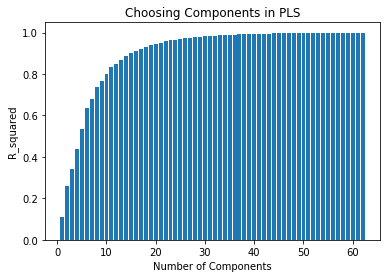

In [ ]:
X_grw_2_pls = get_pls(X_grw_2, y_grw)

In [37]:
X_grw_2_pls = get_pls_comp(X_grw_2, y_grw, 62)

0.9990350082136877


951 features explain around 99% of the variance.951


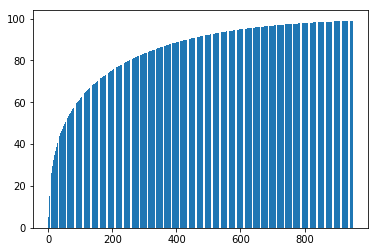

In [38]:
X_grw_3_pca = get_pca(X_grw_3)

119 features explain around 99% of the variance.119


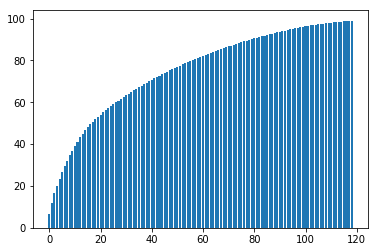

In [39]:
X_grw_4_pca = get_pca(X_grw_4)

13 features explain around 99% of the variance.13


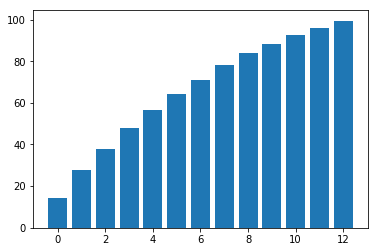

In [40]:
X_grw_5_pca = get_pca(X_grw_5)

In [41]:
X_tfl_2_pls = get_pls_comp(X_tfl_2, y_tfl, 57)

0.999052083814743


In [42]:
X_tfl_3_pls = get_pls_comp(X_tfl_3, y_tfl, 61)

0.9990380999942896


In [43]:
X_tfl_4_pls = get_pls_comp(X_tfl_4, y_tfl, 82)

0.9990690996716386


In [44]:
X_tfl_5_pls = get_pls_comp(X_tfl_5, y_tfl, 300)

0.9933569658704732


242 features explain around 99% of the variance.242


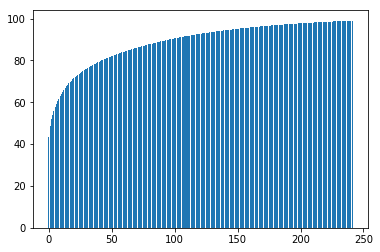

In [45]:
X_tfl_6_pca = get_pca(X_tfl_6)

35 features explain around 99% of the variance.35


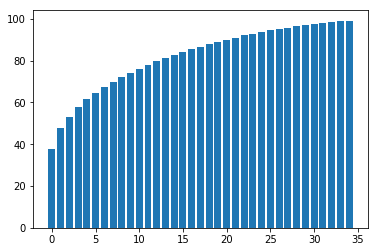

In [46]:
X_tfl_7_pca = get_pca(X_tfl_7)

5 features explain around 99% of the variance.5


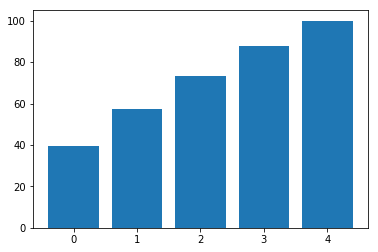

In [47]:
X_tfl_8_pca = get_pca(X_tfl_8)

In [48]:
X_tfl_grw_2_pls = get_pls_comp(X_tfl_grw_2, y_tfl_grw, 200)

0.9984596188350666


35 features explain around 99% of the variance.35


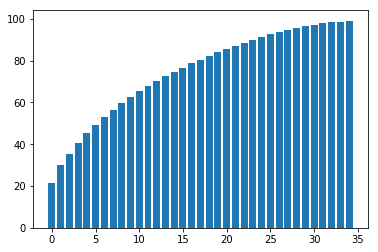

In [49]:
X_tfl_grw_3_pca = get_pca(X_tfl_grw_3)

### 2.2 Machine Learning Models

#### Evaluation method

<b>Mean squared error (MSE)</b> is the average squared difference between the predicted values and observed values. MSE is always greater or equal to zero, the smaller the MSE, the better the model.
$$MSE = \dfrac{1}{N}\sum^N_{i=1}(y_{obs}^{(i)} - y_{pred}^{(i)})^2 $$
<b>R-squared</b> is a statistical measure that represents the proportion of variance for response variation explained by explanatory variation. It is mean that if r-square of the model is 0.7, then 70% observed variation can be explained by input variation.
$$R^2 = 1- \dfrac{explained\,{variance}}{total\,variance} = 1 - \dfrac{\sum^m_{i=1}(y^{(i)}-y^{(i)}_{pred})^2}{\sum^m_{i=1}(y^{(i)}-y^{(i)}_{mean})^2}$$

#### k-fold cross-validation

One divide the data into 10 folds, and take turns to choose 1 fold as a testing set, the other 9 folds as training set for each model. 
Model evaluation metrics are averaged from the MSE and R-squared of the models.

#### Grid Search CV

<b>Grid Search CV</b> is used to select parameters for models, the purpose is to choose the model that achieves the highest accuracy. After choosing the best parameters using grid search cv with the mean squared error metric, one will use those parameters to calculate the r-squared of the model.

#### 2.2.1 Random Forest Regressor

In [63]:
rf_grw_mse = []
rf_grw_r2 = []
rf_tfl_mse = []
rf_tfl_r2 = []
rf_tfl_grw_mse = []
rf_tfl_grw_r2 = []

In [64]:
# Evaluate methods
scoring = ['explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

In [65]:
"""Function to run random forest with grid search and k-fold cross-validation."""
def get_rf_model(X, y):
  # Hyperparameters search grid 
  rf_param_grid = {'bootstrap': [False, True],
          'n_estimators': [60, 70, 80, 90, 100],
          'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
          'min_samples_leaf': [1],
          'min_samples_split': [2]
          }

  # Instantiate random forest regressor
  rf_estimator = RandomForestRegressor(random_state=None)

  # Create the GridSearchCV object
  rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=10, scoring = scoring, refit = 'neg_mean_squared_error', n_jobs=-1)

  # Fine-tune the hyperparameters
  rf_model.fit(X, y)
  print("Best Parameters:\n", rf_model.best_params_)
  print("Best Score:\n", -rf_model.best_score_)
  return(-rf_model.best_score_)

Random forest for grain weight with p-value less than 5e-2

In [66]:
rf_grw_mse_2 = get_rf_model(X_grw_2_pls, y_grw)
rf_grw_mse.append(rf_grw_mse_2)

Best Parameters:
 {'max_features': 0.6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 60, 'bootstrap': False}
Best Score:
 0.06673007252838713


In [126]:
rf_grw_2 = RandomForestRegressor(bootstrap= False, max_features= 0.6, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 60, random_state=None)
rf_grw_r2_2 = cross_val_score(estimator = rf_grw_2, X = X_grw_2_pls, y = y_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:', rf_grw_r2_2.mean())
rf_grw_r2.append(rf_grw_r2_2.mean())

R-squared: 0.6957773234539817


Random forest for grain weight with p-value less than 5e-3

In [69]:
rf_grw_mse_3 = get_rf_model(X_grw_3_pca, y_grw)
rf_grw_mse.append(rf_grw_mse_3)

Best Parameters:
 {'max_features': 0.6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'bootstrap': True}
Best Score:
 0.21230774630812246


In [127]:
rf_grw_3 = RandomForestRegressor(bootstrap= True, max_features= 0.6, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=None)
rf_grw_r2_3 = cross_val_score(estimator = rf_grw_3, X = X_grw_3_pca, y = y_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_grw_r2_3.mean())
rf_grw_r2.append(rf_grw_r2_3.mean())

R-squared: 0.056653390477981055


Random forest for grain weight with p-value less than 5e-4

In [70]:
rf_grw_mse_4 = get_rf_model(X_grw_4_pca, y_grw)
rf_grw_mse.append(rf_grw_mse_4)

Best Parameters:
 {'max_features': 0.75, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 80, 'bootstrap': True}
Best Score:
 0.21829881082743907


In [128]:
rf_grw_4 = RandomForestRegressor(bootstrap= True, max_features= 0.75, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 80, random_state=None)
rf_grw_r2_4 = cross_val_score(estimator = rf_grw_4, X = X_grw_4_pca, y = y_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_grw_r2_4.mean())
rf_grw_r2.append(rf_grw_r2_4.mean())

R-squared: 0.02463761501861598


Random forest for grain weight with p-value less than 5e-5

In [71]:
rf_grw_mse_5 = get_rf_model(X_grw_5_pca, y_grw)
rf_grw_mse.append(rf_grw_mse_5)

Best Parameters:
 {'max_features': 0.6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 70, 'bootstrap': True}
Best Score:
 0.2283588754516306


In [129]:
rf_grw_5 = RandomForestRegressor(bootstrap= True, max_features= 0.6, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 70, random_state=None)
rf_grw_r2_5 = cross_val_score(estimator = rf_grw_5, X = X_grw_5_pca, y = y_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_grw_r2_5.mean())
rf_grw_r2.append(rf_grw_r2_5.mean())

R-squared: -0.013663429775344649


Random forest for time to flowering with p-value less than 5e-2

In [72]:
rf_tfl_mse_2 = get_rf_model(X_tfl_2_pls, y_tfl)
rf_tfl_mse.append(rf_tfl_mse_2)

Best Parameters:
 {'max_features': 0.6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 90, 'bootstrap': False}
Best Score:
 143.52161663000615


In [133]:
rf_tfl_2 = RandomForestRegressor(bootstrap= False, max_features= 0.6, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 90, random_state=None)
rf_tfl_r2_2 = cross_val_score(estimator = rf_tfl_2, X = X_tfl_2_pls, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_tfl_r2_2.mean())
rf_tfl_r2.append(rf_tfl_r2_2.mean())

R-squared: 0.7198994197175418


Random forest for time to flowering with p-value less than 5e-3

In [73]:
rf_tfl_mse_3 = get_rf_model(X_tfl_3_pls, y_tfl)
rf_tfl_mse.append(rf_tfl_mse_3)

Best Parameters:
 {'max_features': 0.6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'bootstrap': False}
Best Score:
 162.20124408774745


In [134]:
rf_tfl_3 = RandomForestRegressor(bootstrap= True, max_features= 0.6, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=None)
rf_tfl_r2_3 = cross_val_score(estimator = rf_tfl_3, X = X_tfl_3_pls, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_tfl_r2_3.mean())
rf_tfl_r2.append(rf_tfl_r2_3.mean())

R-squared: 0.6795712592297816


Random forest for time to flowering with p-value less than 5e-4

In [74]:
rf_tfl_mse_4 = get_rf_model(X_tfl_4_pls, y_tfl)
rf_tfl_mse.append(rf_tfl_mse_4)

Best Parameters:
 {'max_features': 0.8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 80, 'bootstrap': True}
Best Score:
 212.00538130350455


In [135]:
rf_tfl_4 = RandomForestRegressor(bootstrap= True, max_features= 0.8, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 80, random_state=None)
rf_tfl_r2_4 = cross_val_score(estimator = rf_tfl_4, X = X_tfl_4_pls, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_tfl_r2_4.mean())
rf_tfl_r2.append(rf_tfl_r2_4.mean())

R-squared: 0.5811758684769539


Random forest for time to flowering with p-value less than 5e-5

In [75]:
rf_tfl_mse_5 = get_rf_model(X_tfl_5_pls, y_tfl)
rf_tfl_mse.append(rf_tfl_mse_5)

Best Parameters:
 {'max_features': 0.6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 90, 'bootstrap': True}
Best Score:
 355.1740963346082


In [136]:
rf_tfl_5 = RandomForestRegressor(bootstrap= True, max_features= 0.6, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 90, random_state=None)
rf_tfl_r2_5 = cross_val_score(estimator = rf_tfl_5, X = X_tfl_5_pls, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_tfl_r2_5.mean())
rf_tfl_r2.append(rf_tfl_r2_5.mean())

R-squared: 0.3069017309745235


Random forest for time to flowering with p-value less than 5e-6

In [76]:
rf_tfl_mse_6 = get_rf_model(X_tfl_6_pca, y_tfl)
rf_tfl_mse.append(rf_tfl_mse_6)

Best Parameters:
 {'max_features': 0.65, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 90, 'bootstrap': True}
Best Score:
 545.7057145401463


In [137]:
rf_tfl_6 = RandomForestRegressor(bootstrap= True, max_features= 0.65, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 90, random_state=None)
rf_tfl_r2_6 = cross_val_score(estimator = rf_tfl_6, X = X_tfl_6_pca, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_tfl_r2_6.mean())
rf_tfl_r2.append(rf_tfl_r2_6.mean())

R-squared: -0.06421646431674159


Random forest for time to flowering with p-value less than 5e-7

In [77]:
rf_tfl_mse_7 = get_rf_model(X_tfl_7_pca, y_tfl)
rf_tfl_mse.append(rf_tfl_mse_7)

Best Parameters:
 {'max_features': 0.7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 70, 'bootstrap': True}
Best Score:
 583.1727532984427


In [138]:
rf_tfl_7 = RandomForestRegressor(bootstrap= True, max_features= 0.7, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 70, random_state=None)
rf_tfl_r2_7 = cross_val_score(estimator = rf_tfl_7, X = X_tfl_7_pca, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_tfl_r2_7.mean())
rf_tfl_r2.append(rf_tfl_r2_7.mean())

R-squared: -0.15081693155263828


Random forest for time to flowering with p-value less than 5e-8

In [78]:
rf_tfl_mse_8 = get_rf_model(X_tfl_8_pca, y_tfl)
rf_tfl_mse.append(rf_tfl_mse_8)

Best Parameters:
 {'max_features': 0.75, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 60, 'bootstrap': True}
Best Score:
 552.8475957088413


In [139]:
rf_tfl_8 = RandomForestRegressor(bootstrap= True, max_features= 0.75, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 60, random_state=None)
rf_tfl_r2_8 = cross_val_score(estimator = rf_tfl_8, X = X_tfl_8_pca, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_tfl_r2_8.mean())
rf_tfl_r2.append(rf_tfl_r2_8.mean())

R-squared: -0.06746362344191081


Random forest for time to flowering and grain weight with p-value less than 5e-2

In [144]:
rf_tfl_grw_mse_2 = get_rf_model(X_tfl_grw_2_pls, y_tfl_grw)
rf_tfl_grw_mse.append(rf_tfl_grw_mse_2)

Best Parameters:
 {'max_features': 0.8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'bootstrap': True}
Best Score:
 153.1345777271268


In [158]:
rf_tfl_grw_2 = RandomForestRegressor(bootstrap= False, max_features= 0.8, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=None)
rf_tfl_grw_r2_2 = cross_val_score(estimator = rf_tfl_grw_2, X = X_tfl_grw_2_pls, y = y_tfl_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_tfl_grw_r2_2.mean())
rf_tfl_grw_r2.append(rf_tfl_grw_r2_2.mean())

R-squared: 0.22667164744256213


Random forest for time to flowering and grain weight with p-value less than 5e-3

In [145]:
rf_tfl_grw_mse_3 = get_rf_model(X_tfl_grw_3_pca, y_tfl_grw)
rf_tfl_grw_mse.append(rf_tfl_grw_mse_3)

Best Parameters:
 {'max_features': 0.8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 80, 'bootstrap': True}
Best Score:
 305.6289266823951


In [159]:
rf_tfl_grw_3 = RandomForestRegressor(bootstrap= False, max_features= 0.8, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 80, random_state=None)
rf_tfl_grw_r2_3 = cross_val_score(estimator = rf_tfl_grw_3, X = X_tfl_grw_3_pca, y = y_tfl_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',rf_tfl_grw_r2_3.mean())
rf_tfl_grw_r2.append(rf_tfl_grw_r2_3.mean())

R-squared: -0.2699641459135067


#### 2.2.2 Support Vector Machine Regressor

In [81]:
svr_grw_mse = []
svr_grw_r2 = []
svr_tfl_mse = []
svr_tfl_r2 = []
svr_tfl_grw_mse = []
svr_tfl_grw_r2 = []

In [82]:
def get_svm_model(X, y):
  # Parameter grid
  svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 10], "kernel": ["rbf", "poly", "sigmoid"]}  
  # Create SVM grid search regressor
  svm_grid = GridSearchCV(estimator = SVR(), param_grid= svm_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
  # Train the regressor
  svm_grid.fit(X, y)

  print("Best Parameters:\n", svm_grid.best_params_)
  print("Best Score:\n", -svm_grid.best_score_)
  return(-svm_grid.best_score_)

In [83]:
def get_svm_model_not_poly(X, y):
  # Parameter grid 
  svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 10], "kernel": ["rbf","sigmoid"]} 
  # Create SVM grid search regressor
  svm_grid = GridSearchCV(estimator = SVR(), param_grid= svm_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
  # Train the regressor
  svm_grid.fit(X, y)

  print("Best Parameters:\n", svm_grid.best_params_)
  print("Best Score:\n", -svm_grid.best_score_)
  return(-svm_grid.best_score_)

In [84]:
svr_grw_mse_2 = get_svm_model(X_grw_2_pls, y_grw)
svr_grw_mse.append(svr_grw_mse_2)

Best Parameters:
 {'C': 0.1, 'gamma': 0.0001, 'kernel': 'sigmoid'}
Best Score:
 0.004944871224330078


In [146]:
svr_grw_2 = SVR(C = 0.1, gamma = 0.0001, kernel = 'sigmoid')
svr_grw_r2_2= cross_val_score(estimator = svr_grw_2, X = X_grw_2_pls, y = y_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_grw_r2_2.mean())
svr_grw_r2.append(svr_grw_r2_2.mean())

R-squared: 0.9779751763122133


In [85]:
svr_grw_mse_3 = get_svm_model_not_poly(X_grw_3_pca, y_grw)
svr_grw_mse.append(svr_grw_mse_3)

Best Parameters:
 {'C': 1, 'gamma': 0.0001, 'kernel': 'sigmoid'}
Best Score:
 0.19201640219425326


In [147]:
svr_grw_3 = SVR(C = 1, gamma = 0.0001, kernel = 'sigmoid')
svr_grw_r2_3 = cross_val_score(estimator = svr_grw_3, X = X_grw_3_pca, y = y_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_grw_r2_3.mean())
svr_grw_r2.append(svr_grw_r2_3.mean())

R-squared: 0.14935469187688893


In [86]:
svr_grw_mse_4 = get_svm_model_not_poly(X_grw_4_pca, y_grw)
svr_grw_mse.append(svr_grw_mse_4)

Best Parameters:
 {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score:
 0.21037681409584902


In [148]:
svr_grw_4 = SVR(C = 1, gamma = 0.0001, kernel = 'rbf')
svr_grw_r2_4 = cross_val_score(estimator = svr_grw_4, X = X_grw_4_pca, y = y_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_grw_r2_4.mean())
svr_grw_r2.append(svr_grw_r2_4.mean())

R-squared: 0.07019754070630599


In [87]:
svr_grw_mse_5 = get_svm_model_not_poly(X_grw_5_pca, y_grw)
svr_grw_mse.append(svr_grw_mse_5)

Best Parameters:
 {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score:
 0.2276695720780616


In [149]:
svr_grw_5 = SVR(C = 0.1, gamma = 0.01, kernel = 'rbf')
svr_grw_r2_5 = cross_val_score(estimator = svr_grw_5, X = X_grw_5_pca, y = y_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_grw_r2_5.mean())
svr_grw_r2.append(svr_grw_r2_5.mean())

R-squared: -0.00462418648048023


In [88]:
svr_tfl_mse_2 = get_svm_model(X_tfl_2_pls, y_tfl)
svr_tfl_mse.append(svr_tfl_mse_2)

Best Parameters:
 {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score:
 56.06325275161315


In [150]:
svr_tfl_2 = SVR(C = 100, gamma = 0.0001, kernel = 'rbf')
svr_tfl_r2_2 = cross_val_score(estimator = svr_tfl_2, X = X_tfl_2_pls, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_tfl_r2_2.mean())
svr_tfl_r2.append(svr_tfl_r2_2.mean())

R-squared: 0.8911774392940999


In [89]:
svr_tfl_mse_3 = get_svm_model(X_tfl_3_pls, y_tfl)
svr_tfl_mse.append(svr_tfl_mse_3)

Best Parameters:
 {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score:
 12.636909645729169


In [151]:
svr_tfl_3 = SVR(C = 100, gamma = 0.0001, kernel = 'rbf')
svr_tfl_r2_3 = cross_val_score(estimator = svr_tfl_3, X = X_tfl_3_pls, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_tfl_r2_3.mean())
svr_tfl_r2.append(svr_tfl_r2_3.mean())

R-squared: 0.9753886236422342


In [90]:
svr_tfl_mse_4 = get_svm_model(X_tfl_4_pls, y_tfl)
svr_tfl_mse.append(svr_tfl_mse_4)

Best Parameters:
 {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score:
 2.681097821571568


In [152]:
svr_tfl_4 = SVR(C = 100, gamma = 0.0001, kernel = 'rbf')
svr_tfl_r2_4 = cross_val_score(estimator = svr_tfl_4, X = X_tfl_4_pls, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_tfl_r2_4.mean())
svr_tfl_r2.append(svr_tfl_r2_4.mean())

R-squared: 0.9947569683169221


In [91]:
svr_tfl_mse_5 = get_svm_model(X_tfl_5_pls, y_tfl)
svr_tfl_mse.append(svr_tfl_mse_5)

Best Parameters:
 {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score:
 8.943451299147808


In [153]:
svr_tfl_5 = SVR(C = 100, gamma = 0.0001, kernel = 'rbf')
svr_tfl_r2_5 = cross_val_score(estimator = svr_tfl_5, X = X_tfl_5_pls, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_tfl_r2_5.mean())
svr_tfl_r2.append(svr_tfl_r2_5.mean())

R-squared: 0.9824866652146588


In [92]:
svr_tfl_mse_6 = get_svm_model_not_poly(X_tfl_6_pca, y_tfl)
svr_tfl_mse.append(svr_tfl_mse_6)

Best Parameters:
 {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score:
 538.7043812316134


In [154]:
svr_tfl_6 = SVR(C = 10, gamma = 0.0001, kernel = 'rbf')
svr_tfl_r2_6 = cross_val_score(estimator = svr_tfl_6, X = X_tfl_6_pca, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_tfl_r2_6.mean())
svr_tfl_r2.append(svr_tfl_r2_6.mean())

R-squared: -0.042206089573184814


In [93]:
svr_tfl_mse_7 = get_svm_model_not_poly(X_tfl_7_pca, y_tfl)
svr_tfl_mse.append(svr_tfl_mse_7)

Best Parameters:
 {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
Best Score:
 538.1772798465767


In [155]:
svr_tfl_7 = SVR(C = 10, gamma = 0.001, kernel = 'sigmoid')
svr_tfl_r2_7 = cross_val_score(estimator = svr_tfl_7, X = X_tfl_7_pca, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_tfl_r2_7.mean())
svr_tfl_r2.append(svr_tfl_r2_7.mean())

R-squared: -0.04084826982419741


In [94]:
svr_tfl_mse_8 = get_svm_model_not_poly(X_tfl_8_pca, y_tfl)
svr_tfl_mse.append(svr_tfl_mse_8)

Best Parameters:
 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score:
 540.8689846761142


In [156]:
svr_tfl_8 = SVR(C = 100, gamma = 0.001, kernel = 'rbf')
svr_tfl_r2_8 = cross_val_score(estimator = svr_tfl_8, X = X_tfl_8_pca, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:',svr_tfl_r2_8.mean())
svr_tfl_r2.append(svr_tfl_r2_8.mean())

R-squared: -0.04584549475132514


#### 2.2.3 Lasso and Multi Task Lasso

In [136]:
def get_lasso_cv(X, y):

  # Parameter grid
  ls_param_grid = {'alpha': [ 0.1, 0.01, 0.001, 0.0001, 1, 10, 100]} 
  # Create Lasso grid search regressor
  ls_grid = GridSearchCV(estimator = Lasso(), param_grid= ls_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
#copy_X=False, normalize = True
  # Train the regressor
  ls_grid.fit(X, y)

  print("Best Parameters:\n", ls_grid.best_params_)
  print("Best Score:\n", -ls_grid.best_score_)

  model_lasso = Lasso(alpha = ls_grid.best_params_['alpha']).fit(X, y)
  coef = pd.DataFrame(model_lasso.coef_.T, index = X.columns)

  var = list(coef[coef[0] != 0].index)
  print(coef.head())
  print("Lasso picked " + str(sum(coef[0] != 0)) + " variables and eliminated the other " +  str(sum(coef[0] == 0)) + " variables")
  print("CV Results:\n", ls_grid.cv_results_)
  return(var)

In [135]:
def get_multitask_lasso_cv(X, y):

  # Parameter grid
  ls_param_grid = {'alpha': [ 0.1, 0.01, 0.001, 0.0001, 1, 10, 100]} 
  # Create Lasso grid search regressor
  ls_grid = GridSearchCV(estimator = MultiTaskLasso(), param_grid= ls_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
#copy_X=False, normalize = True
  # Train the regressor
  ls_grid.fit(X, y)

  print("Best Parameters:\n", ls_grid.best_params_)
  print("Best Score:\n", -ls_grid.best_score_)

  model_lasso = MultiTaskLasso(alpha = ls_grid.best_params_['alpha']).fit(X, y)
  coef = pd.DataFrame(model_lasso.coef_.T, index = X.columns)
  var = list(coef[coef[0] != 0].index)
  print(coef.head())
  print("Lasso picked " + str(sum(coef[0] != 0)) + " variables and eliminated the other " +  str(sum(coef[0] == 0)) + " variables")
  print("CV Results:\n", ls_grid.cv_results_)
  return(var)

In [ ]:
var_tfl_ls = get_lasso_cv(X_cont, y_tfl)

In [ ]:
lasso_tfl = Lasso(alpha = 0.01)
r2_tfl= cross_val_score(estimator = lasso_tfl , X = X_cont, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:', r2_tfl.mean())

In [ ]:
var_grw_ls = get_lasso_cv(X_cont, y_grw)

In [ ]:
lasso_grw = Lasso(alpha = 0.01)
r2_grw= cross_val_score(estimator = lasso_grw , X = X_cont, y = y_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:', r2_grw.mean())

In [ ]:
var_tfl_grw_ls = get_multitask_lasso_cv(X_cont, y_tfl_grw)

In [ ]:
lasso_tfl_grw = MultiTaskLasso(alpha = 1)
r2_tfl_grw= cross_val_score(estimator = lasso_tfl_grw , X = X_cont, y = y_tfl_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:', r2_tfl_grw.mean())

In [ ]:
var_tfl_ls.to_csv('gs://bi-rice-data/var_tfl_ls.csv')
var_grw_ls.to_csv('gs://bi-rice-data/var_grw_ls.csv')
var_tfl_grw_ls.to_csv('gs://bi-rice-data/var_tfl_grw_ls.csv')

#### 2.2.4 Elastic Net and Multi Task Elastic Net

In [ ]:
def get_elasticnet(X, y): 
  # Parameter grid
  el_param_grid = {'alpha': [ 0.1, 0.01, 0.001, 0.0001, 1, 10, 100], 'l1_ratio': [0, 0.5, 1]} 
  # Create Lasso grid search regressor
  el_grid = GridSearchCV(estimator = ElasticNet(), param_grid= el_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
  # Train the regressor
  el_grid.fit(X, y)

  print("Best Parameters:\n", el_grid.best_params_)
  print("Best Score:\n", -el_grid.best_score_)

  model_lasso = ElasticNet(alpha = el_grid.best_params_['alpha']).fit(X, y)
  coef = pd.DataFrame(model_lasso.coef_.T, index = X.columns)

  var = list(coef[coef[0] != 0].index)
  print(coef.head())
  print("ElasticNet picked " + str(sum(coef[0] != 0)) + " variables and eliminated the other " +  str(sum(coef[0] == 0)) + " variables")
  print("CV Results:\n", el_grid.cv_results_)
  return(var)

In [ ]:
def get_multitask_elasticnet(X, y): 
  # Parameter grid
  el_param_grid = {'alpha': [ 0.1, 0.01, 0.001, 0.0001, 1, 10, 100], 'l1_ratio': [0, 0.5, 1]} 
  # Create Lasso grid search regressor
  el_grid = GridSearchCV(estimator = MultiTaskElasticNet(), param_grid= el_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
  # Train the regressor
  el_grid.fit(X, y)

  print("Best Parameters:\n", el_grid.best_params_)
  print("Best Score:\n", -el_grid.best_score_)

  model_lasso = MultiTaskElasticNet(alpha = el_grid.best_params_['alpha']).fit(X, y)
  coef = pd.DataFrame(model_lasso.coef_.T, index = X.columns)

  var = list(coef[coef[0] != 0].index)
  print(coef.head())
  print("ElasticNet picked " + str(sum(coef[0] != 0)) + " variables and eliminated the other " +  str(sum(coef[0] == 0)) + " variables")
  print("CV Results:\n", el_grid.cv_results_)
  return(var)

In [ ]:
var_tfl_el = get_elasticnet(X_cont, y_tfl)

In [ ]:
el_tfl = ElasticNet(alpha = 1, l1_ratio = 0)
r2_tfl_el= cross_val_score(estimator = el_tfl  , X = X_cont, y = y_tfl, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:', r2_tfl_el.mean())

In [ ]:
var_grw_el = get_elasticnet(X_cont, y_grw)

In [ ]:
el_grw = ElasticNet(alpha = 1, l1_ratio = 0)
r2_grw_el= cross_val_score(estimator = el_grw  , X = X_cont, y = y_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:', r2_grw_el.mean())

In [ ]:
var_tfl_grw_el = get_multitask_elasticnet(X_cont, y_tfl_grw)

In [ ]:
el_tfl_grw = ElasticNet(alpha = 1, l1_ratio = 0)
r2_tfl_grw_el= cross_val_score(estimator = el_tfl_grw  , X = X_cont, y = y_tfl_grw, scoring='r2', cv=10, n_jobs=-1)
print('R-squared:', r2_tfl_grw_el.mean())

In [ ]:
var_tfl_el.to_csv('gs://bi-rice-data/var_tfl_el.csv')
var_grw_el.to_csv('gs://bi-rice-data/var_grw_el.csv')
var_tfl_grw_el.to_csv('gs://bi-rice-data/var_tfl_grw_el.csv')

## 3 Results

One will compare r-squared and root mean square error between random forest model and support vector machine model.

In [173]:
p_value = ['<=5e-8','<=5e-7', '<=5e-6', '<=5e-5', '<=5e-4', '<=5e-3', '<=5e-2']

In [189]:
grw_mse = pd.DataFrame({'rf_grw_mse':rf_grw_mse[::-1], 'svr_grw_mse':svr_grw_mse[::-1]})
grw_mse.set_index(pd.Index(p_value[3:7]), 'p_value', inplace = True)

grw_r2 = pd.DataFrame({'rf_grw_r2':rf_grw_r2[::-1], 'svr_grw_r2':svr_grw_r2[::-1]})
grw_r2.set_index(pd.Index(p_value[3:7]), 'p_value', inplace = True)

tfl_mse = pd.DataFrame({'rf_tfl_mse':rf_tfl_mse[::-1], 'svr_tfl_mse':svr_tfl_mse[::-1]})
tfl_mse.set_index(pd.Index(p_value), 'p_value', inplace = True)

tfl_r2 = pd.DataFrame({'rf_tfl_r2':rf_tfl_r2[::-1], 'svr_tfl_r2':svr_tfl_r2[::-1]})
tfl_r2.set_index(pd.Index(p_value), 'p_value', inplace = True)

tfl_grw_mse = pd.DataFrame({'rf_tfl_grw_mse':rf_tfl_grw_mse[::-1]})
tfl_grw_mse.set_index(pd.Index(p_value[5:7]), 'p_value', inplace = True)

tfl_grw_r2 = pd.DataFrame({'rf_tfl_grw_r2':rf_tfl_grw_r2[::-1]})
tfl_grw_r2.set_index(pd.Index(p_value[5:7]), 'p_value', inplace = True)

### 3.1 Output Data Is Grain Weight

Mean squared error between random forest and support vector machine.

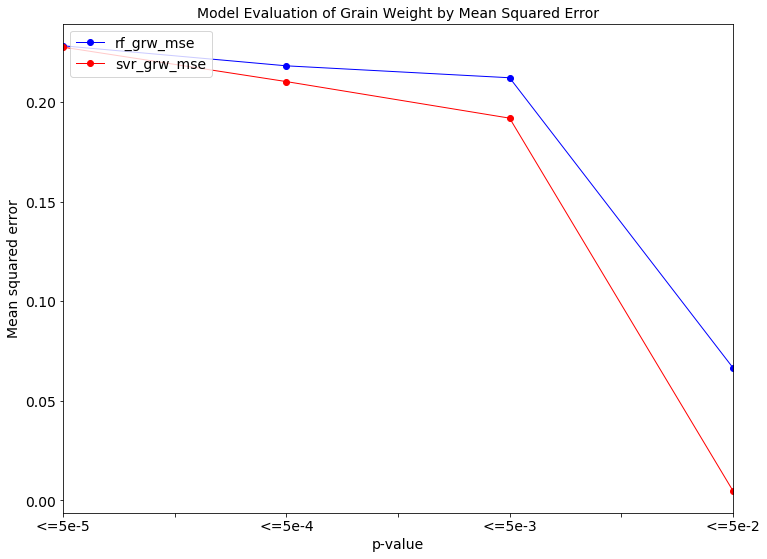

In [193]:
styles = ['bo-','ro-']
linewidths = [1, 1]
fig, ax = plt.subplots()

for col, style, lw in zip(grw_mse.columns, styles, linewidths):
    grw_mse[col].plot(style=style, lw=lw, ax=ax, figsize = (12, 9), fontsize = 14 )

plt.xlabel('p-value', fontsize=14)
plt.ylabel('Mean squared error', fontsize=14) 
plt. title('Model Evaluation of Grain Weight by Mean Squared Error', fontsize=14)
plt.legend(loc=2, prop={'size': 14})

R-squared between random forest and support vector machine.

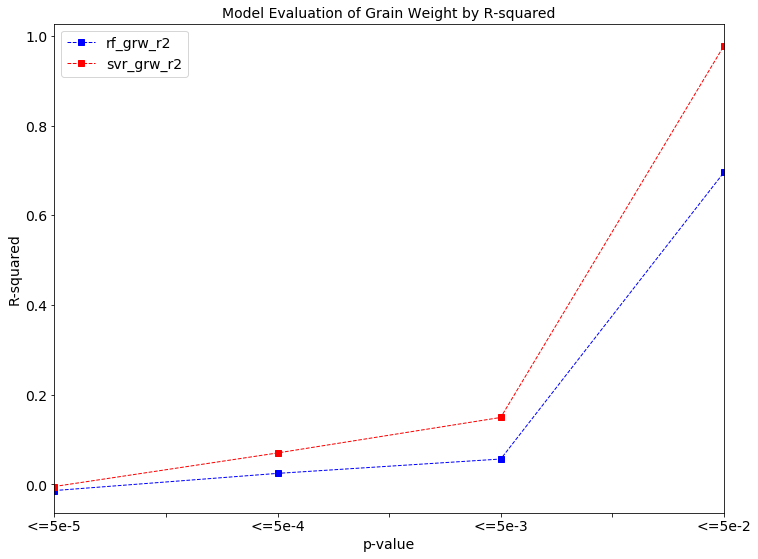

In [192]:
styles = ['bs--','rs--']
linewidths = [1, 1]
fig, ax = plt.subplots()

for col, style, lw in zip(grw_r2.columns, styles, linewidths):
    grw_r2[col].plot(style=style, lw=lw, ax=ax, figsize = (12, 9), fontsize = 14 )

plt.xlabel('p-value', fontsize=14)
plt.ylabel('R-squared', fontsize=14) 
plt. title('Model Evaluation of Grain Weight by R-squared', fontsize=14)
plt.legend(loc=2, prop={'size': 14})

### 3.2 Output Data Is Time to Flowering

Mean squared error between random forest and support vector machine.

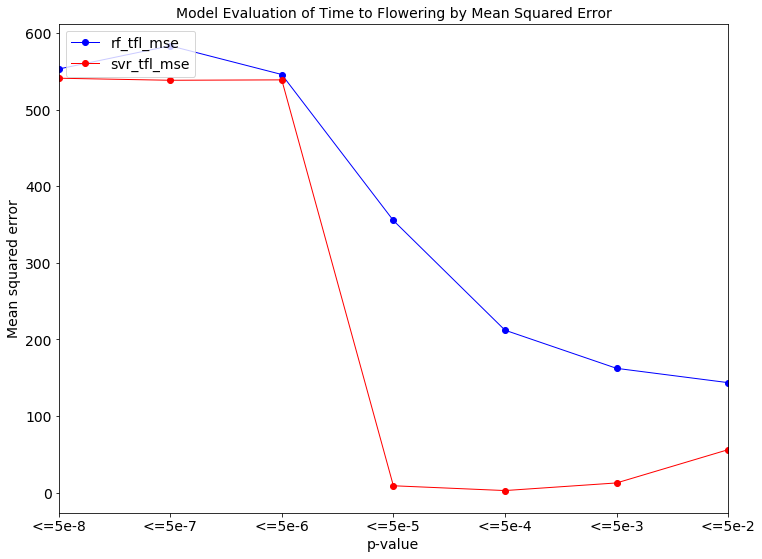

In [194]:
styles = ['bo-','ro-']
linewidths = [1, 1]
fig, ax = plt.subplots()

for col, style, lw in zip(tfl_mse.columns, styles, linewidths):
    tfl_mse[col].plot(style=style, lw=lw, ax=ax, figsize = (12, 9), fontsize = 14 )

plt.xlabel('p-value', fontsize=14)
plt.ylabel('Mean squared error', fontsize=14) 
plt. title('Model Evaluation of Time to Flowering by Mean Squared Error', fontsize=14)
plt.legend(loc=2, prop={'size': 14})

R-squared between random forest and support vector machine.

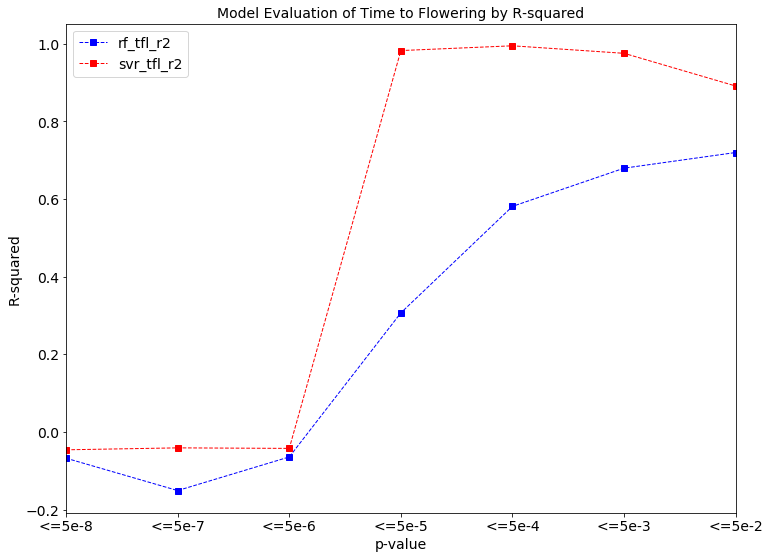

In [195]:
styles = ['bs--','rs--']
linewidths = [1, 1]
fig, ax = plt.subplots()

for col, style, lw in zip(tfl_r2.columns, styles, linewidths):
    tfl_r2[col].plot(style=style, lw=lw, ax=ax, figsize = (12, 9), fontsize = 14 )

plt.xlabel('p-value', fontsize=14)
plt.ylabel('R-squared', fontsize=14) 
plt. title('Model Evaluation of Time to Flowering by R-squared', fontsize=14)
plt.legend(loc=2, prop={'size': 14})

### 3.3 Output Data Is Time to Flowering and Grain Weight

Mean squared error of random forest.

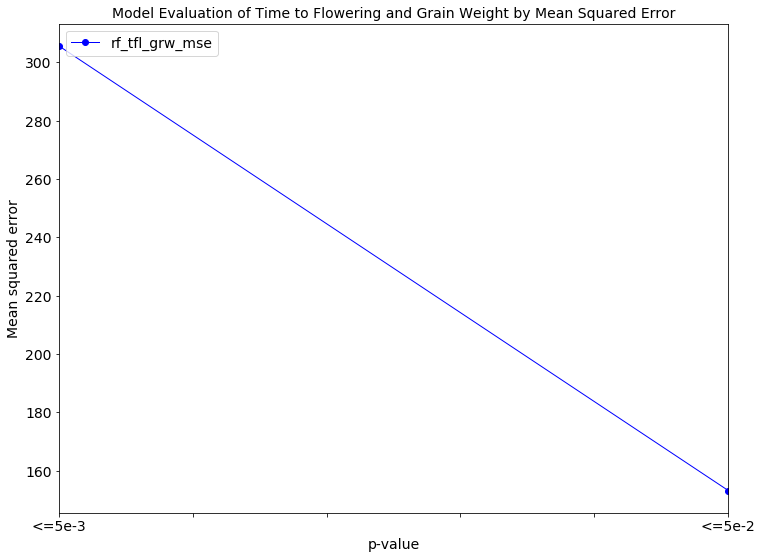

In [196]:
styles = ['bo-','ro-']
linewidths = [1, 1]
fig, ax = plt.subplots()

for col, style, lw in zip(tfl_grw_mse.columns, styles, linewidths):
    tfl_grw_mse[col].plot(style=style, lw=lw, ax=ax, figsize = (12, 9), fontsize = 14 )

plt.xlabel('p-value', fontsize=14)
plt.ylabel('Mean squared error', fontsize=14) 
plt. title('Model Evaluation of Time to Flowering and Grain Weight by Mean Squared Error', fontsize=14)
plt.legend(loc=2, prop={'size': 14})

In [ ]:
R-squared of random forest.

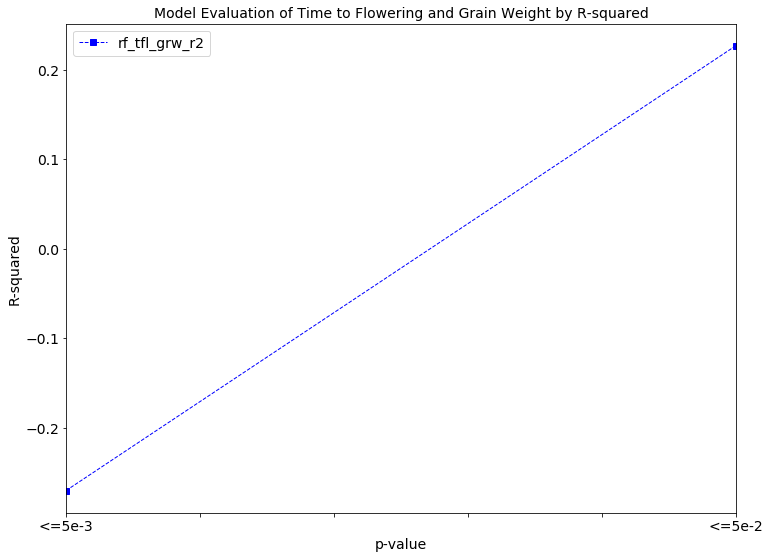

In [198]:
styles = ['bs--','rs--']
linewidths = [1, 1]
fig, ax = plt.subplots()

for col, style, lw in zip(tfl_grw_r2.columns, styles, linewidths):
    tfl_grw_r2[col].plot(style=style, lw=lw, ax=ax, figsize = (12, 9), fontsize = 14 )

plt.xlabel('p-value', fontsize=14)
plt.ylabel('R-squared', fontsize=14) 
plt. title('Model Evaluation of Time to Flowering and Grain Weight by R-squared', fontsize=14)
plt.legend(loc=2, prop={'size': 14})